# Simple Steps to Train Your Neural Network

- Step 1: Problem Definition
    - Input $x$
    - Output $y$
- Step 2: Data Preparation
    - Download and Formatting Data: torch.utils.data.Dataset, torch.utils.data.DataLoader
    - Data Preprocessing: torchvision.transforms
- Step 3: Model Architecture Design $f$
    - torch.nn (Example: 2-Layer Neural Network)
- Step 4: Loss Function Design $l(f(x), y)$
    - torch.nn.functional (Example: CrossEntropyLoss)
- Step 5: Optimizer Selection $\min l(f(x), y)$
    - torch.optim (Example: mini-batch SGD)
- Iteration:
    - Step 7: Train the Neural Network
        - Convergence, Loss curve  
    - Step 8: Validate the Model
        - Train / Validation / Test
    - Step 9: Evaluate the Model
        - Accuracy
    - Step 10: Model Tuning, Break if Got an Ideal Model
        - Tuning hyperparameters

## Step 1: Problem Definition

Image Classification:

Input: 
- modality: image
- datatype: uint8
- shape:(224, 224, 3)
- ranging: [0, 255]

Output: 
- label: car, frog, ..., N classes
- datatype: long
- shape: (1,)
- ranging: [0, N-1]

## Step 2: Prepare the Data

recall that you have already used the `trainset` and `testset` in your assignment1:

In [1]:
# 环境与库导入 + 版本信息
import sys, torch, torchvision, torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np, os, random
from torch import nn
from torch import optim

os.makedirs('results', exist_ok=True)
print('Python:', sys.version)
print('Torch:', torch.__version__)
print('Device:', 'cuda' if torch.cuda.is_available() else 'cpu')

# 固定随机种子
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 基础可视化设置
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['image.cmap'] = 'gray'

# CIFAR10 基础 transform
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

Python: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Torch: 2.2.1+cpu
Device: cpu


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train batches: 79 Test batches: 13
Train batches: 79 Test batches: 13


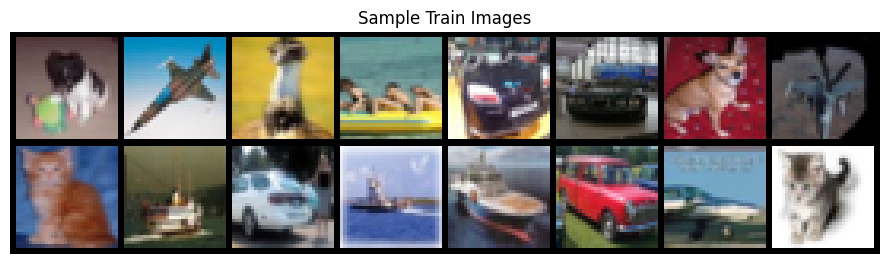

Saved -> results/cifar10_samples.png


In [2]:
# 数据加载（使用子集加速）
from torch.utils.data import Dataset, DataLoader

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=basic_transform)
full_test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=basic_transform)

# 取子集（如需全量，改为 len(full_train) / len(full_test)）
train_count = 5000
test_count = 800
indices_train = list(range(train_count))
indices_test  = list(range(test_count))

subset_train = torch.utils.data.Subset(full_train, indices_train)
subset_test  = torch.utils.data.Subset(full_test, indices_test)

trainloader = DataLoader(subset_train, batch_size=64, shuffle=True, num_workers=0)
testloader  = DataLoader(subset_test, batch_size=64, shuffle=False, num_workers=0)

classes = full_train.classes
print('Train batches:', len(trainloader), 'Test batches:', len(testloader))

# 可视化若干样本并保存
dataiter = iter(trainloader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[:16], nrow=8, padding=2, normalize=True)
plt.figure(figsize=(9,4))
plt.imshow(np.transpose(img_grid.numpy(), (1,2,0)))
plt.title('Sample Train Images')
plt.axis('off')
plt.tight_layout()
plt.savefig('results/cifar10_samples.png', dpi=140)
plt.show()
print('Saved -> results/cifar10_samples.png')

# Step 3: Model Architecture Design

In [3]:
# 模型定义（两层 MLP 或简易 CNN，可切换）
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),              # 16x16
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),              # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN().to(device)
print(model)
print('Total params: %.2fK' % (sum(p.numel() for p in model.parameters())/1e3))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 可选：学习率调度器（简单阶梯）
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
Total params: 1116.97K

Total params: 1116.97K


## An example to understand the concept of `model`, `training`, `loss`


suppose we have 50 `data` with 1 dimention, we want to design a function $f$ (we will call it a `model` in the next few months), such that the curve of function `fits` the data

observing the data curve, we easily identify that it could be perfect if the function is a `sin/cos(x)`. Therefore we define the function as:

$$f(x) = a\sin(bx+c) + d$$

and simply define a L2 penalty, when the function does not predict well (we will call it `loss`):

$$\min_{a,b,c,d}J(a,b,c,d)={(f(x) - y)^{2}}$$

here, a,b,c,d are `parameters`

How to `optimize` the `parameters` in order to minimize the loss?

Understanding Gradient descent via an Example:

at first, a,b,c,d are randomly initialized, therefore the loss is large, suppose the parameter-loss curve be like (not the real curve of our loss): 
<img src="./GD.png">

after optimizing the parameters through gradient descent, the function `diverges` in `local minima`

Specifically, the gradient is the derivative of the function, i.e., $\frac{\delta f}{\delta a}$.

Going along the direction of derivatives step by step, the gradient descent is formulated as:

$$ w_i = w_i - \alpha\cdot \frac{\delta J(w)}{\delta w}, w=[a,b,c,d]$$

the $\alpha$ is `learning rate`, determining the length that you update the parameters.

Here we have N samples, therefore the formula is actually calculated as:

$$ w_i = w_i - \alpha\cdot \frac{1}{N} \Sigma_{j=0}^{N} \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d]$$


variants of gradient descent:

we call the number of sample used in one update as `batch_size`

- Batch GD: update parameter using the whole training data
$$ w_i = w_i - \alpha\cdot \frac{1}{N} \Sigma_{j=0}^{N} \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d]$$
- Stochastic GD: update parameter using only one sample
$$ w_i = w_i - \alpha\cdot \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d]$$
- Mini-Batch GD: update parameter using a mini batch of sample
$$ w_i = w_i - \alpha\cdot \frac{1}{m} \Sigma_{j=0}^{m} \frac{\delta J_j(w)}{\delta w}, w=[a,b,c,d], m<N$$



Epoch 1/8 DONE | train_loss=2.2993 train_acc=0.1386 test_loss=2.2804 test_acc=0.1525 | time=3.7s
Epoch 2/8 DONE | train_loss=2.1604 train_acc=0.2040 test_loss=2.0625 test_acc=0.2662 | time=4.0s
Epoch 2/8 DONE | train_loss=2.1604 train_acc=0.2040 test_loss=2.0625 test_acc=0.2662 | time=4.0s
Epoch 3/8 DONE | train_loss=1.9327 train_acc=0.3036 test_loss=1.8082 test_acc=0.3525 | time=4.1s
Epoch 3/8 DONE | train_loss=1.9327 train_acc=0.3036 test_loss=1.8082 test_acc=0.3525 | time=4.1s
Epoch 4/8 DONE | train_loss=1.7683 train_acc=0.3600 test_loss=1.7094 test_acc=0.3725 | time=3.9s
Epoch 4/8 DONE | train_loss=1.7683 train_acc=0.3600 test_loss=1.7094 test_acc=0.3725 | time=3.9s
Epoch 5/8 DONE | train_loss=1.6542 train_acc=0.4098 test_loss=1.6596 test_acc=0.3887 | time=3.8s
Epoch 5/8 DONE | train_loss=1.6542 train_acc=0.4098 test_loss=1.6596 test_acc=0.3887 | time=3.8s
Epoch 6/8 DONE | train_loss=1.5129 train_acc=0.4526 test_loss=1.5717 test_acc=0.4238 | time=3.7s
Epoch 6/8 DONE | train_loss=1.

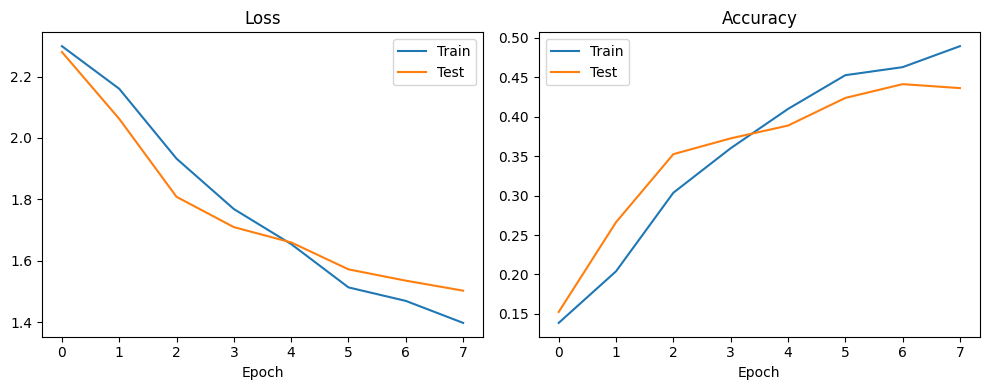

Saved -> results/cifar10_curves.png
Saved -> results/cifar10_metrics.json


In [4]:
import time, json, matplotlib.pyplot as plt

history = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[]}

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            pred = out.argmax(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return total_loss/total, correct/total

num_epochs = 8  # 可调整
print_interval = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    start = time.time()
    for step,(x,y) in enumerate(trainloader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        running_correct += out.argmax(1).eq(y).sum().item()
        running_total += y.size(0)

        if (step+1) % print_interval == 0:
            print(f'Epoch {epoch+1}/{num_epochs} Step {step+1} TrainLoss={(running_loss/running_total):.4f}')

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total
    test_loss, test_acc = evaluate(testloader)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs} DONE | train_loss={train_loss:.4f} train_acc={train_acc:.4f} test_loss={test_loss:.4f} test_acc={test_acc:.4f} | time={time.time()-start:.1f}s')

# 保存曲线
os.makedirs('results', exist_ok=True)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.legend()
plt.tight_layout()
plt.savefig('results/cifar10_curves.png', dpi=160)
plt.show()
print('Saved -> results/cifar10_curves.png')

# 指标 JSON
metrics = {
    'final_train_loss': history['train_loss'][-1],
    'final_test_loss': history['test_loss'][-1],
    'final_train_acc': history['train_acc'][-1],
    'final_test_acc': history['test_acc'][-1],
    'epochs': num_epochs
}
with open('results/cifar10_metrics.json','w',encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)
print('Saved -> results/cifar10_metrics.json')

Impact of:
- Larger model size (More hidden state each layer; More layers)
- Different optimizer (e.g. torch.optim.Adam, torch.optim.AdamW)
- Novel architecture (e.g., Dropout, BatchNormalization, etc.)
- Weight initialization (e.g. xavier)
- Novel loss / regularization (e.g. l2)
- hyper-parameters (e.g. Batchsize, learning rate, etc.)

a playground by Google: https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-gauss&learningRate=0.03&regularizationRate=0&noise=0&networkShape=5,2,2&seed=0.07966&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false


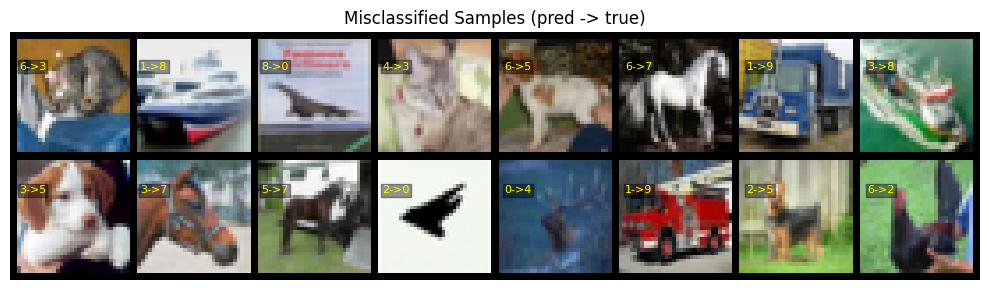

Saved -> results/cifar10_misclassified.png


In [5]:
# 保存误分类样本可视化
import itertools
model.eval()
mis_images = []
mis_preds = []
mis_trues = []
with torch.no_grad():
    for x,y in testloader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        mask = pred.ne(y)
        if mask.any():
            sel = mask.nonzero(as_tuple=True)[0]
            for idx in sel:
                mis_images.append(x[idx].cpu())
                mis_preds.append(int(pred[idx].cpu()))
                mis_trues.append(int(y[idx].cpu()))
                if len(mis_images) >= 16:
                    break
        if len(mis_images) >= 16:
            break

if mis_images:
    grid = torchvision.utils.make_grid(mis_images, nrow=8, normalize=True, padding=2)
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title('Misclassified Samples (pred -> true)')
    plt.axis('off')
    for i,(p,t) in enumerate(zip(mis_preds, mis_trues)):
        plt.text((i%8)* (grid.shape[2]/8) + 2, (i//8)* (grid.shape[1]/2) + 10, f'{p}->{t}', color='yellow', fontsize=8, bbox=dict(facecolor='black', alpha=0.4, pad=1))
    plt.tight_layout()
    plt.savefig('results/cifar10_misclassified.png', dpi=160)
    plt.show()
    print('Saved -> results/cifar10_misclassified.png')
else:
    print('No misclassified samples collected (all correct in sampled batches).')

Saved model weights -> results/cifar10_model.pth


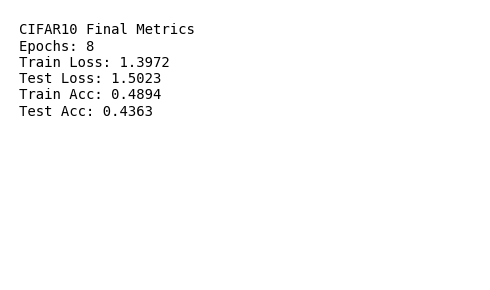

Saved -> results/cifar10_final_metrics.png


In [6]:
# 保存模型权重与最终文本图像
import torch, json, matplotlib.pyplot as plt, os
os.makedirs('results', exist_ok=True)
model_path = 'results/cifar10_model.pth'
torch.save(model.state_dict(), model_path)
print('Saved model weights ->', model_path)

with open('results/cifar10_metrics.json','r',encoding='utf-8') as f:
    m = json.load(f)

text_lines = [
    'CIFAR10 Final Metrics',
    f"Epochs: {m['epochs']}",
    f"Train Loss: {m['final_train_loss']:.4f}",
    f"Test Loss: {m['final_test_loss']:.4f}",
    f"Train Acc: {m['final_train_acc']:.4f}",
    f"Test Acc: {m['final_test_acc']:.4f}",
]
plt.figure(figsize=(5,3))
plt.axis('off')
plt.text(0.02,0.95,'\n'.join(text_lines), va='top', ha='left', family='monospace')
plt.tight_layout()
plt.savefig('results/cifar10_final_metrics.png', dpi=160)
plt.show()
print('Saved -> results/cifar10_final_metrics.png')